In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn

from models import DGI, LogReg
from utils import process
from scipy.sparse import csr_matrix



In [7]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

C:\Users\jbryb\virual_envs_python\pytorch_env\lib\site-packages\torch_geometric\datasets\karate.py:32: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  adj = nx.to_scipy_sparse_matrix(G).tocoo()


In [8]:
data = dataset[0] 

In [9]:
features_karate = data.x
type(features_karate)

torch.Tensor

In [10]:
# Load and process features
features_karate = csr_matrix(features_karate).tolil()
features_karate, _ = process.preprocess_features(features_karate)
features_karate = torch.FloatTensor(features_karate[np.newaxis])

In [11]:
# Load and proces grpah & adjacency matrix

import networkx as nx

G = nx.karate_club_graph()

A = nx.adjacency_matrix(G)

A = process.normalize_adj(A + sp.eye(A.shape[0]))


sp_A = process.sparse_mx_to_torch_sparse_tensor(A)

# features = torch.FloatTensor(features[np.newaxis])

C:\Users\jbryb\AppData\Local\Temp\ipykernel_9336\3433633071.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
C:\Users\jbryb\virual_envs_python\pytorch_env\lib\site-packages\networkx\linalg\graphmatrix.py:173: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  return nx.to_scipy_sparse_matrix(G, nodelist=nodelist, dtype=dtype, weight=weight)


In [12]:
type(sp_A)

torch.Tensor

In [13]:
# training params
batch_size = 1
nb_epochs = 1000
patience = 60
lr = 0.01
l2_coef = 1e-5
drop_prob = 0.0
# specify size of encoding vector:
hid_units = 2 # 512
sparse = True
nonlinearity = 'prelu' # special name to separate parameters

# Model Karate

In [14]:

nb_nodes = features_karate.shape[1]
ft_size = features_karate.shape[2]
# nb_classes = labels.shape[1]

labels = [] # torch.FloatTensor(labels[np.newaxis])

idx_train = np.arange(len(list(G.nodes)))
idx_val = np.arange(len(list(G.nodes)))
idx_test = np.arange(len(list(G.nodes)))

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [15]:
model = DGI(ft_size, hid_units, nonlinearity)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)

# b_xent applies logits follwoed by cross-entropy loss
b_xent = nn.BCEWithLogitsLoss()
# xent = nn.CrossEntropyLoss()

# cnt_wait counts epochs from the last bes tmodel and implemnts early stopping
cnt_wait = 0
# initial best score for loss
best = 1e9
best_t = 0

loss_history = list()

for epoch in range(nb_epochs):
    model.train()
    optimiser.zero_grad()

    idx = np.random.permutation(nb_nodes)
    # reshuffle features
    shuf_fts = features_karate[:, idx, :]
    # vector of ones, length = number of nodes
    lbl_1 = torch.ones(batch_size, nb_nodes)
    # vector of zeros, length = number of nodes 
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    # length = 2*number of nodes, i.e. 5416
    lbl = torch.cat((lbl_1, lbl_2), 1)

    # the "if" affects onle "sparse" vs "sp_adj"
    # i.e. mask = None, samp_bias1 = None, samp_bias2 = None
    logits = model(features_karate, shuf_fts, sp_A if sparse else adj, sparse, None, None, None) 

    loss = b_xent(logits, lbl)
    loss_history.append(loss.detach().numpy()) # use detach to get rid of the gradient

    print('Loss:', loss)

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), 'best_dgi.pkl')
    else:
        cnt_wait += 1

    if cnt_wait == patience:
        print('Early stopping!')
        break

    loss.backward()
    optimiser.step()

print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load('best_dgi.pkl'))




Loss: tensor(0.6926, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6918, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6916, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6901, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6917, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6929, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6914, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6882, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6877, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6901, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6891,

Loss: tensor(0.5106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5127, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4913, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5503, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5353, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5806, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5997, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4568, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5342, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5435, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4893, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5382, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5599, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5431,

Loss: tensor(0.6622, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6072, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4527, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4888, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5410, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5270, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4198, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4511, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6301, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6385, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6462, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6231, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.6300, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.5575, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Loss: tensor(0.4678,

<All keys matched successfully>

In [16]:
h, s = model.embed(features_karate, sp_A, msk = None, sparse = True )

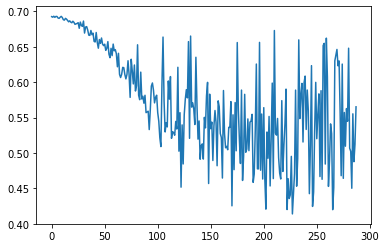

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [18]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

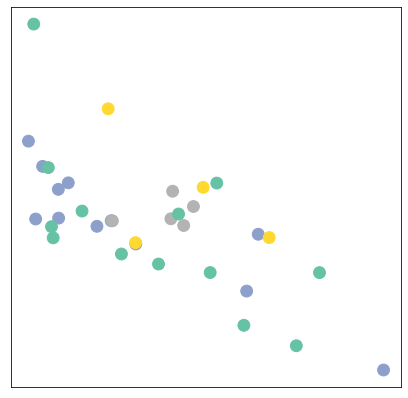

In [19]:
visualize_embedding(h[0, :,:], data.y, epoch=None, loss=None)